In [1]:
# 주피터 가로로 넓게 쓰기
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import pandas as pd
import numpy as np

import time 
import datetime as dt
from datetime import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn-whitegrid')

import pickle
import joblib

# ML Library

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, GroupKFold

from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_absolute_error

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek # 오버 샘플링 성능 비교용 
from imblearn.under_sampling import TomekLinks

from adamp import AdamP
from tensorflow_addons.optimizers import AdamW

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GRU, Dropout, Dense, Conv1D
from tensorflow.keras import models

print("Setup Complete")

Setup Complete


In [3]:
path = "/home/kym/ML/input/kamp/대회 과제"
os.chdir(path)
model_path = path

df = pd.read_csv('melting_tank_mod.csv', encoding='cp949')

feature = [
    f for f in df.columns if f not in ("NUM")
]

df = df[feature]
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S', errors='coerce'))
df.set_index('STD_DT', inplace=True)

df.to_csv('/home/kym/ML/input/kamp/대회 과제/melting_tank_final.csv', index=False)
df.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-04,48.9,11.6,631,1
2020-03-04,43.3,7.8,609,1
2020-03-04,46.4,15.4,608,1
2020-03-04,37.9,21.2,606,1
2020-03-04,79.8,173.6,604,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:00
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MELT_TEMP    835200 non-null  float64
 1   MOTORSPEED   835200 non-null  float64
 2   MELT_WEIGHT  835200 non-null  int64  
 3   TAG          835200 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 31.9 MB


In [5]:
# 표준 편차가 큰 feature 인 재료의 질량은 관찰 그래프를 통해 극히 영향도가 미미한 것을 알았기에 제외하고, 탱크 온도와 모터 속도만으로 학습함. 
df.describe().T.style.bar(subset=['mean'], color='#205ff2').background_gradient(subset=['std'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
MELT_TEMP,835200.000000,50.920062,12.827752,30.800000,43.000000,46.900000,50.200000,83.200000
MOTORSPEED,835200.000000,45.978287,63.943641,0.000000,11.900000,16.800000,21.800000,180.400000
MELT_WEIGHT,835200.000000,414.582481,317.234065,0.000000,186.000000,382.000000,579.000000,2820.000000
TAG,835200.000000,0.787994,0.408729,0.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# 전체 데이터 83 만여개를 모두 사용하여 학습할 경우 real time detection 이 전부 정상으로 나오는 문제가 발생함.
# 따라서, 정상 구간 부분을 버리고 OK / NG 가 모두 존재하는 부분만 학습을 진행함. 

start_point = 189000
end_point = 580000

df = df.iloc[start_point:end_point, :]
df.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-17 03:00:00,44.9,14.8,626,1
2020-03-17 03:00:00,45.6,7.3,627,1
2020-03-17 03:00:00,48.1,16.8,630,1
2020-03-17 03:00:00,43.9,21.5,647,1
2020-03-17 03:00:00,74.5,175.3,648,1


In [7]:
df.shape

(391000, 4)

In [8]:
df.columns

Index(['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'TAG'], dtype='object')

In [9]:
df = df[['MELT_TEMP', 'MOTORSPEED', 'TAG']]

In [10]:
split_date = int(df.shape[0] * 0.7)

train = df[:split_date]
test = df[split_date:]

In [11]:
scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [12]:
x_train_values = train_sc[:, :-1]
y_train_values = train_sc[:, -1]

In [13]:
smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42)
x_train_over, y_train_over = smoteto.fit_resample(x_train_values, y_train_values)

print("SMOTETomek 적용 전 학습용 피처 / 라벨 세트: ", x_train_values.shape, y_train_values.shape)
print("SMOTETomek 적용 후 학습용 피처 / 라벨 세트: ", x_train_over.shape, y_train_over.shape)
print("SMOTETomek 적용 후 라벨 값 분포: \n", pd.Series(y_train_over).value_counts())

SMOTETomek 적용 전 학습용 피처 / 라벨 세트:  (273700, 2) (273700,)
SMOTETomek 적용 후 학습용 피처 / 라벨 세트:  (281451, 2) (281451,)
SMOTETomek 적용 후 라벨 값 분포: 
 1.0    140817
0.0    140634
dtype: int64


In [14]:
def make_dataset(df, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(df) - window_size):
        feature_list.append(np.array(df.iloc[i : i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
        
    return np.array(feature_list), np.array(label_list)

In [15]:
# dataframe
x_train_over = pd.DataFrame(x_train_over, columns=['MELT_TEMP', 'MOTORSPEED'])
y_train_over = pd.DataFrame(y_train_over, columns=['TAG'])

In [17]:
# window size = 10
train_feature, train_label = make_dataset(x_train_over, y_train_over, 10)
train_feature.shape, train_label.shape

((281441, 10, 2), (281441, 1))

In [18]:
test_sc = pd.DataFrame(test_sc, columns=['MELT_TEMP', 'MOTORSPEED', 'TAG'])

In [19]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED']
label_cols = ['TAG']

In [20]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 10)

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)
x_train.shape, x_valid.shape

((197008, 10, 2), (84433, 10, 2))

### Model

In [22]:
model = Sequential()
model.add(GRU(64,
              input_shape=(train_feature.shape[1], train_feature.shape[2]),
              activation='tanh',
              return_sequences=True)
         )
model.add(tf.keras.layers.Dropout(0.2))
model.add(GRU(16,
              activation='tanh',
              return_sequences=True)
         )
model.add(tf.keras.layers.Dropout(0.2))
model.add(GRU(4,
              activation='tanh',
              return_sequences=False)
         )
model.add(Dense(1, activation='sigmoid'))
model.summary()

2022-11-26 15:23:37.485811: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-26 15:23:37.485831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kym-System-Product-Name
2022-11-26 15:23:37.485835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kym-System-Product-Name
2022-11-26 15:23:37.485918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-11-26 15:23:37.485930: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-11-26 15:23:37.485933: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-11-26 15:23:37.486104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructi

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 64)            13056     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 10, 16)            3936      
                                                                 
 dropout_1 (Dropout)         (None, 10, 16)            0         
                                                                 
 gru_2 (GRU)                 (None, 4)                 264       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 17,261
Trainable params: 17,261
Non-traina

In [23]:
# Aactivation function 

# step = tf.Variable(0, trainable=False)
# schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#     [10000, 15000], [1e-0, 1e-1, 1e-2])
# # lr and wd can be a function or a tensor
# lr = 1e-3 * schedule(step)
# wd = lambda: 1e-4 * schedule(step)

# AdamW

In [24]:
# 현실 고려 시 FN (음성으로 예측했는데 실제로 양성인 것 = 정상 (1) 으로 예측했는데 실제로 불량 (0) 인 것) 을 중점적으로 개선해야 한다. 

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adamax(), metrics=[tf.keras.metrics.AUC(curve='ROC')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.003)
filename = os.path.join(model_path, 'melting_tank_pretrained_model.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')

In [25]:
history = model.fit(x_train, y_train,
                   epochs=20,
                   batch_size=64,
                   validation_data=(x_valid, y_valid),
                   callbacks=[early_stop, checkpoint])

Epoch 1/20
3074/3079 [============================>.] - ETA: 0s - loss: 0.5098 - auc: 0.8073
Epoch 00001: val_loss improved from inf to 0.44910, saving model to /home/kym/ML/input/kamp/대회 과제/melting_tank_pretrained_model.h5
3079/3079 [==============================] - 37s 11ms/step - loss: 0.5097 - auc: 0.8074 - val_loss: 0.4491 - val_auc: 0.8614
Epoch 2/20
3077/3079 [============================>.] - ETA: 0s - loss: 0.4354 - auc: 0.8659
Epoch 00002: val_loss improved from 0.44910 to 0.40964, saving model to /home/kym/ML/input/kamp/대회 과제/melting_tank_pretrained_model.h5
3079/3079 [==============================] - 35s 11ms/step - loss: 0.4354 - auc: 0.8659 - val_loss: 0.4096 - val_auc: 0.8802
Epoch 3/20
3075/3079 [============================>.] - ETA: 0s - loss: 0.4003 - auc: 0.8834
Epoch 00003: val_loss improved from 0.40964 to 0.38672, saving model to /home/kym/ML/input/kamp/대회 과제/melting_tank_pretrained_model.h5
3079/3079 [==============================] - 34s 11ms/step - loss: 0.4

In [26]:
scaler_filename = "mx_rscaler.pkl"
joblib.dump(scaler, scaler_filename)

['mx_rscaler.pkl']

In [27]:
model.load_weights('melting_tank_pretrained_model.h5')
pred = model.predict(test_feature)

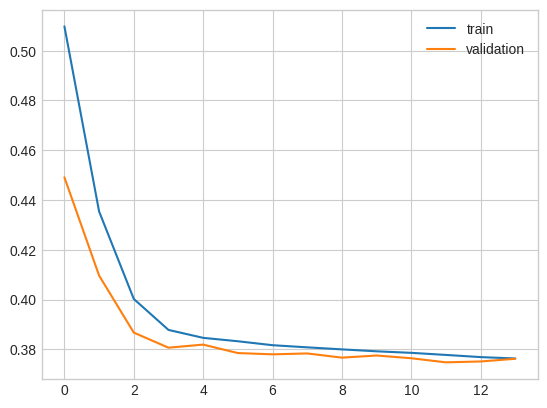

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [29]:
pred_df = pd.DataFrame(pred, columns=['TAG'])
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x >= 0.5 else 0)

In [30]:
# 1 정상, 0 불량
pred_df['TAG'].value_counts()

1    70388
0    46902
Name: TAG, dtype: int64

In [31]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        1 # print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

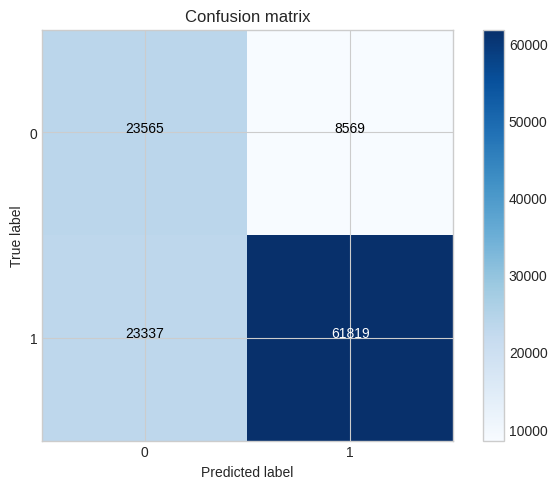

In [32]:
# 연속된 공정은 실제 불량을 정상으로 예측하는 FN 을 줄여야 함. 실제 정상을 불량으로 예측 시 설비를 정지시키는 수준이지만, 실제 불량을 정상 예측할 경우 다음 공정까지
# 투입되는 모든 비용을 망치게 된다. 따라서 재현율 (recall) 중점으로 봐야 함. 

classify = confusion_matrix(test_label, pred_df)

plt.figure()
plot_confusion_matrix(classify, classes=[0, 1], title='Confusion matrix')
plt.show()

In [33]:
print(classify)

[[23565  8569]
 [23337 61819]]


In [34]:
p = precision_score(test_label, pred_df)
print("precision: %0.4f" %p)
r = recall_score(test_label, pred_df)
print("recall: %0.4f" %r)
f1 = f1_score(test_label, pred_df)
print("f1-score: %0.4f" %f1)
acc = accuracy_score(test_label, pred_df)
print("accuracy: %0.4f" %acc)

precision: 0.8783
recall: 0.7260
f1-score: 0.7949
accuracy: 0.7280


f1-score: 0.7949


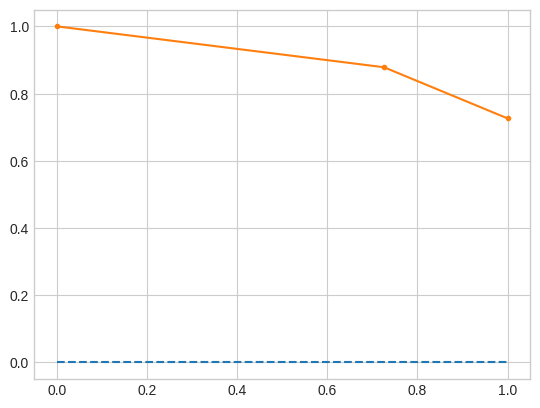

In [35]:
precision, recall, thresholds = precision_recall_curve(test_label, pred_df)

print("f1-score: %0.4f" %f1)
plt.plot([0, 1], [0, 0], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show()